In [13]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Remplace 'nom_du_fichier.csv' par le chemin réel de ton fichier CSV
chemin_fichier = 'flickr_data2.csv'

# Lecture du fichier CSV
try:
    data = pd.read_csv(chemin_fichier, sep=',')
    print("Fichier importé avec succès !")
except Exception as e:
    print(f"Une erreur est survenue : {e}")

Fichier importé avec succès !


C:\Users\mf\AppData\Local\Temp\ipykernel_42888\73834050.py:11: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(chemin_fichier, sep=',')


In [2]:
print("### Informations générales sur le dataset ###")
print(data.info())

# Nombre total de lignes et colonnes
print("\nNombre total de lignes et colonnes :")
print(f"Lignes : {data.shape[0]}, Colonnes : {data.shape[1]}")

# Statistiques descriptives
print("\n### Statistiques descriptives ###")
#print(data.describe(include='all'))  # Inclut toutes les colonnes

# Comptage des valeurs nulles par colonne
print("\n### Nombre de valeurs nulles par colonne ###")
print(data.isnull().sum())

# Pourcentage de valeurs nulles
print("\n### Pourcentage de valeurs nulles par colonne ###")
print((data.isnull().sum() / data.shape[0]) * 100)

# Détection des doublons
print("\n### Nombre de doublons ###")
print(data.duplicated().sum())

# Aperçu des premières lignes
print("\n### Aperçu des premières lignes ###")
print(data.head())


### Informations générales sur le dataset ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420240 entries, 0 to 420239
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   420240 non-null  int64  
 1    user                420240 non-null  object 
 2    lat                 420240 non-null  float64
 3    long                420240 non-null  float64
 4    tags                316730 non-null  object 
 5    title               381911 non-null  object 
 6    date_taken_minute   420239 non-null  float64
 7    date_taken_hour     420240 non-null  int64  
 8    date_taken_day      420240 non-null  int64  
 9    date_taken_month    420240 non-null  int64  
 10   date_taken_year     420240 non-null  int64  
 11   date_upload_minute  420228 non-null  object 
 12   date_upload_hour    420238 non-null  object 
 13   date_upload_day     420238 non-null  float64
 14   date_upload_month   4

In [3]:

try:
    # Suppression des doublons sur toutes les colonnes
    data_sans_doublons = data.drop_duplicates()
    print("Les doublons ont été supprimés du dataset.")

    # Identifier les 3 dernières colonnes
    dernieres_colonnes = data_sans_doublons.columns[-3:]  # Noms des 3 dernières colonnes
    print("### Les 3 dernières colonnes identifiées sont : ###")
    print(dernieres_colonnes)

    # Filtrer les lignes où au moins une des 3 dernières colonnes contient une valeur non nulle
    lignes_problemes = data_sans_doublons[dernieres_colonnes].notnull().any(axis=1)

    lignes_problemes_df = data_sans_doublons[lignes_problemes]

    lignes_problemes_df['title_date_concat'] = (
    lignes_problemes_df[' title'].astype(str) + '_:' + lignes_problemes_df[' date_upload_minute'].astype(str)
    )
    # Réassigner les colonnes en utilisant .loc
    lignes_problemes_df.loc[:, ' date_upload_minute'] = lignes_problemes_df[' date_upload_hour']
    lignes_problemes_df.loc[:, ' date_upload_hour'] = lignes_problemes_df[' date_upload_day']
    lignes_problemes_df.loc[:, ' date_upload_day'] = lignes_problemes_df[' date_upload_month']
    lignes_problemes_df.loc[:, ' date_upload_month'] = lignes_problemes_df[' date_upload_year']
    lignes_problemes_df.loc[:, ' date_upload_year'] = lignes_problemes_df['Unnamed: 16']
    lignes_problemes_df.loc[:, ' title'] = lignes_problemes_df['title_date_concat']

    lignes_problemes_df['annee'] = lignes_problemes_df[' date_taken_minute']
    lignes_problemes_df.loc[:, ' date_taken_minute'] = lignes_problemes_df[' date_taken_hour']
    lignes_problemes_df.loc[:,' date_taken_hour'] = lignes_problemes_df[' date_taken_day']
    lignes_problemes_df.loc[:,' date_taken_day'] = lignes_problemes_df[' date_taken_month']
    lignes_problemes_df.loc[:,' date_taken_month'] = lignes_problemes_df[' date_taken_year']
    lignes_problemes_df.loc[:,' date_taken_year'] = lignes_problemes_df['annee']

    lignes_problemes_df.drop(columns=['annee', 'title_date_concat', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18' ], inplace=True)

    # Liste des IDs à supprimer
    ids_a_supprimer = [8744184885, 8715425964]

    # Suppression des lignes correspondant aux IDs spécifiés
    lignes_problemes_df = lignes_problemes_df[~lignes_problemes_df['id'].isin(ids_a_supprimer)]

except Exception as e:
    print(f"Une erreur est survenue : {e}")


Les doublons ont été supprimés du dataset.
### Les 3 dernières colonnes identifiées sont : ###
Index(['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'], dtype='object')


C:\Users\mf\AppData\Local\Temp\ipykernel_42888\2207322591.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lignes_problemes_df['title_date_concat'] = (
C:\Users\mf\AppData\Local\Temp\ipykernel_42888\2207322591.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lignes_problemes_df['annee'] = lignes_problemes_df[' date_taken_minute']
C:\Users\mf\AppData\Local\Temp\ipykernel_42888\2207322591.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

In [4]:
ids_problemes = lignes_problemes_df['id'].tolist()  # Liste des IDs corrigés
df_base = data_sans_doublons[~data_sans_doublons['id'].isin(ids_problemes)]
df_base.drop(columns=['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18' ], inplace=True)
# Ajouter les lignes corrigées au DataFrame de base
df_base = pd.concat([df_base, lignes_problemes_df], ignore_index=True)


C:\Users\mf\AppData\Local\Temp\ipykernel_42888\1733496353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base.drop(columns=['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18' ], inplace=True)


In [5]:
print(lignes_problemes_df.columns)

Index(['id', ' user', ' lat', ' long', ' tags', ' title', ' date_taken_minute',
       ' date_taken_hour', ' date_taken_day', ' date_taken_month',
       ' date_taken_year', ' date_upload_minute', ' date_upload_hour',
       ' date_upload_day', ' date_upload_month', ' date_upload_year'],
      dtype='object')


In [6]:
import folium
from folium.plugins import MarkerCluster


m = folium.Map([45.7640, 4.8357], zoom_start=12)

#Ajouter un marqueur pour chaque donnée non nulle dans les colonnes 'lat' et 'long' des données sans doublons
sampled_data = data_sans_doublons.sample(1000, random_state=42)

marker_cluster = MarkerCluster().add_to(m)

for lat, long in zip(sampled_data[' lat'], sampled_data[' long']):
    folium.Marker(
        location=[lat, long],
        popup=f"Point ({lat}, {long})"
    ).add_to(marker_cluster)


m



In [30]:
sampled_data = data_sans_doublons.sample(1000, random_state=42)
#new df with only user lat and long
sampled_data = sampled_data[[' lat', ' long']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sampled_data)

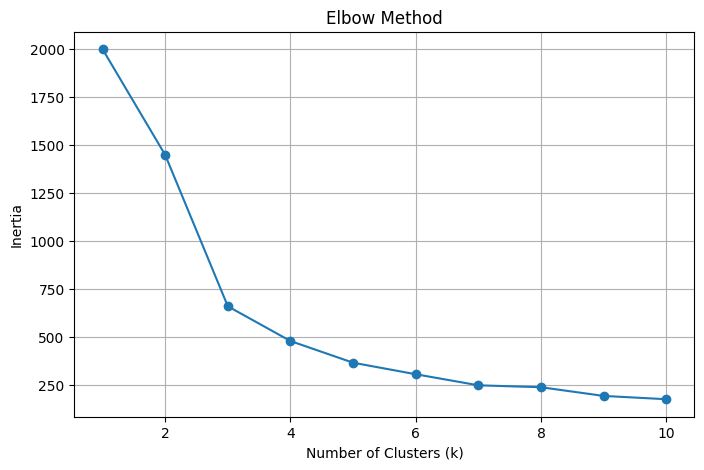

In [29]:
# Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

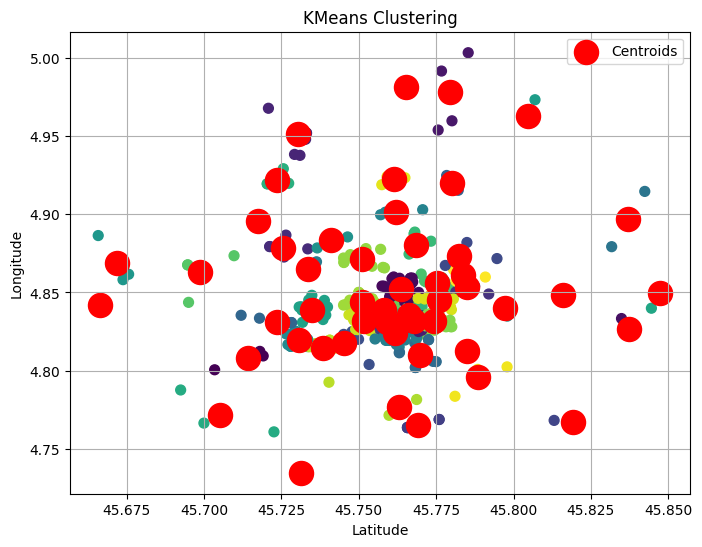

In [35]:
# Perform KMeans clustering with the chosen number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels back to the original sampled data
sampled_data['Cluster'] = kmeans.labels_

# Visualization of clusters
plt.figure(figsize=(8, 6))
plt.scatter(
    sampled_data[' lat'], sampled_data[' long'], 
    c=sampled_data['Cluster'], cmap='viridis', s=50
)
plt.scatter(
    scaler.inverse_transform(kmeans.cluster_centers_)[:, 0], 
    scaler.inverse_transform(kmeans.cluster_centers_)[:, 1], 
    s=300, c='red', label='Centroids'
)
plt.title("KMeans Clustering")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

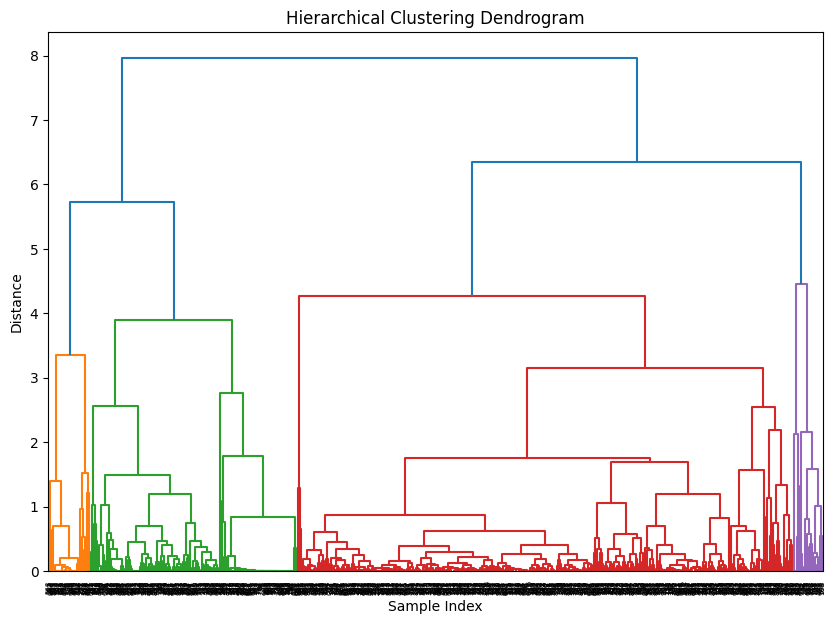

In [43]:
# Compute linkage matrix
linkage_matrix = linkage(scaled_data, method='complete')  # 'ward', 'single', 'complete', etc.

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


In [46]:
# Define the number of clusters
num_clusters = 170

# Assign cluster labels
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add cluster labels to the DataFrame
sampled_data['Cluster'] = cluster_labels


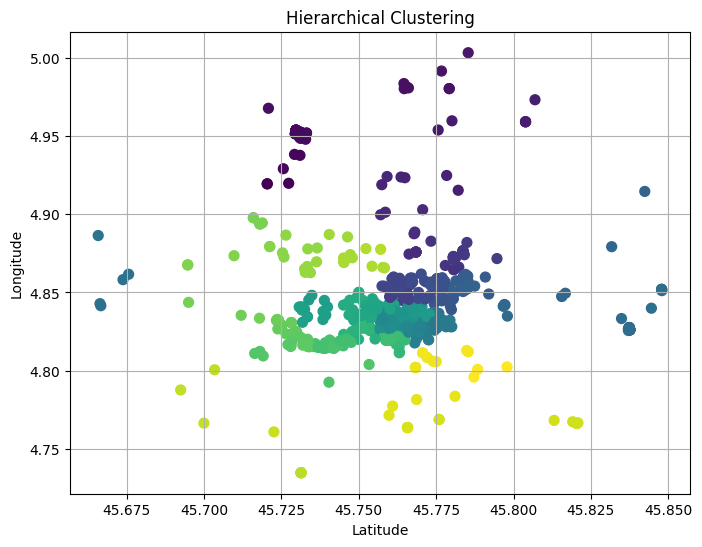

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(
    sampled_data[' lat'], sampled_data[' long'], 
    c=sampled_data['Cluster'], cmap='viridis', s=50
)
plt.title("Hierarchical Clustering")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid(True)
plt.show()
